# Homework_0
## Real Time Machine Learning
### Authors: Mark McAfoose

In [1]:
pip install ptflops

Note: you may need to restart the kernel to use updated packages.


# This output means nothing to my homework, however was having trouble getting torchvision to work so just copied and pasted from website on assignment

In [2]:
import torchvision.models as models
import torch
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  net = models.densenet161()
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

DenseNet(
  28.681 M, 100.000% Params, 7.818 GMac, 100.000% MACs, 
  (features): Sequential(
    26.472 M, 92.298% Params, 7.816 GMac, 99.972% MACs, 
    (conv0): Conv2d(0.014 M, 0.049% Params, 0.177 GMac, 2.264% MACs, 3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(0.0 M, 0.001% Params, 0.002 GMac, 0.031% MACs, 96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(0.0 M, 0.000% Params, 0.001 GMac, 0.015% MACs, inplace=True)
    (pool0): MaxPool2d(0.0 M, 0.000% Params, 0.001 GMac, 0.015% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      0.751 M, 2.620% Params, 2.364 GMac, 30.237% MACs, 
      (denselayer1): _DenseLayer(
        0.102 M, 0.355% Params, 0.321 GMac, 4.101% MACs, 
        (norm1): BatchNorm2d(0.0 M, 0.001% Params, 0.001 GMac, 0.008% MACs, 96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(0.0 M, 0.0

# Real Beginning of Project

In [3]:
import torch
from torchvision import models

In [5]:
#Problem 1
resnet101 = models.resnet101(pretrained=True)

In [6]:
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )])

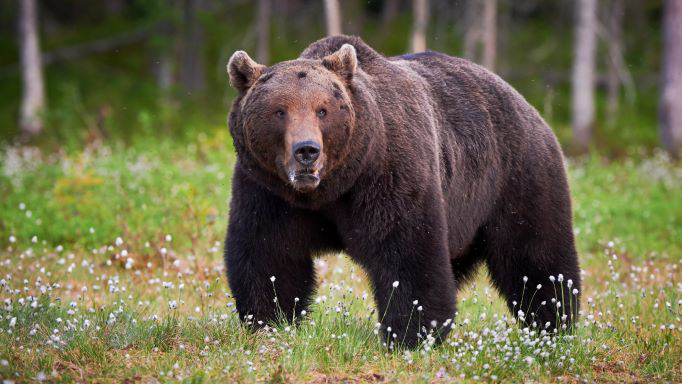

In [82]:
from PIL import Image
Bear = Image.open("Bear.jpg")
Bear

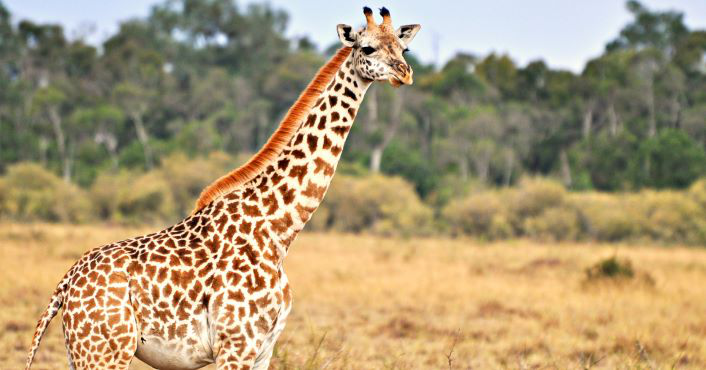

In [83]:
Giraffe = Image.open("Giraffe.jpg")
Giraffe

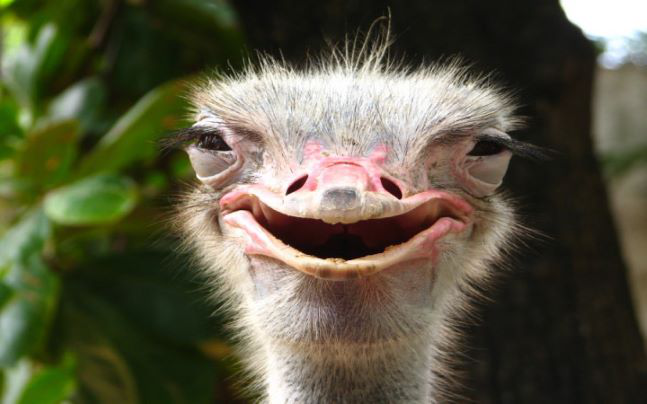

In [84]:
Ostrich = Image.open("Ostrich.jpg")
Ostrich

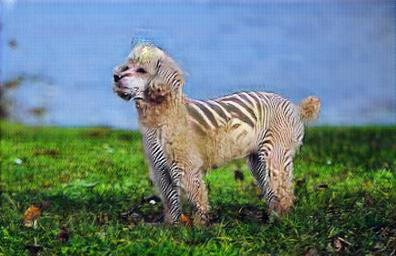

In [10]:
Poodle = Image.open("Poodle.jpg")
Poodle

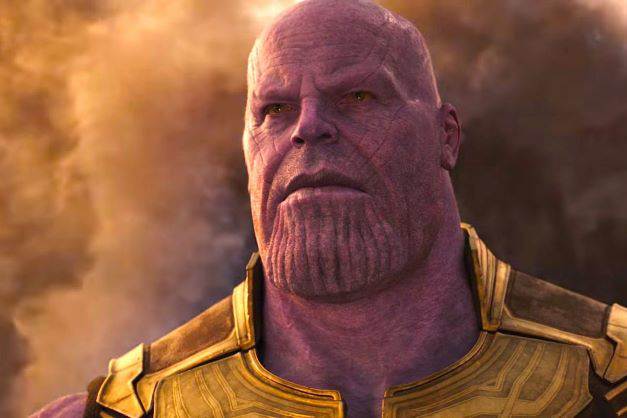

In [85]:
Thanos = Image.open("Thanos.jpg")
Thanos

In [64]:
#Preprocess image
img_t = preprocess(Thanos) #replace variable in arg to desired image
batch_t = torch.unsqueeze(img_t, 0)

In [65]:
#Evaluate
resnet101.eval()
out = resnet101(batch_t)

In [14]:
#Get class labels
with open("imagenet_classes.txt") as f:
    labels = [line.strip() for line in f.readlines()]

In [15]:
#Generate classification results
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('military uniform', 16.551645278930664),
 ('pickelhaube', 14.038186073303223),
 ('shield, buckler', 10.555941581726074),
 ('rifle', 10.21405029296875),
 ('breastplate, aegis, egis', 6.929413318634033)]

In [16]:
#Problem 2
import torch
import torch.nn as nn

#Required Classes from the reference reading
class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [17]:
netG = ResNetGenerator() #generate model
model_path = "horse2zebra_0.4.0.pth"
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [18]:
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

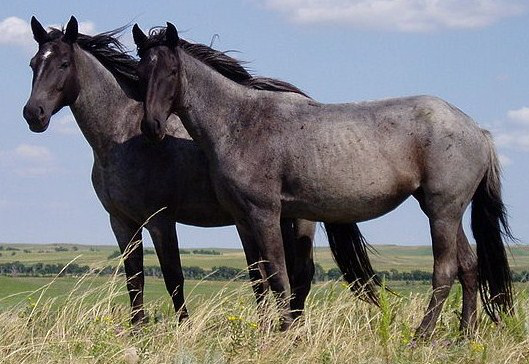

In [86]:
from PIL import Image
from torchvision import transforms
preprocess = transforms.Compose([transforms.Resize(256),
    transforms.ToTensor()])
img1 = Image.open("Horse1.jpg")
img1

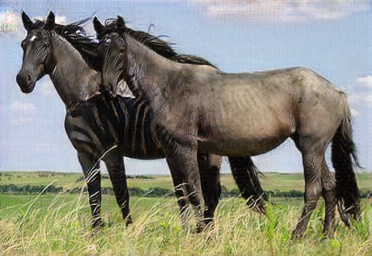

In [20]:
img_t1 = preprocess(img1)
batch_z1 = torch.unsqueeze(img_t1, 0)
batch_out1 = netG(batch_z1)
#Run image through model and obtain altered image
out_t1 = (batch_out1.data.squeeze() + 1.0) / 2.0
out_img1 = transforms.ToPILImage()(out_t1)
out_img1.save("Zebra1.jpg")
out_img1

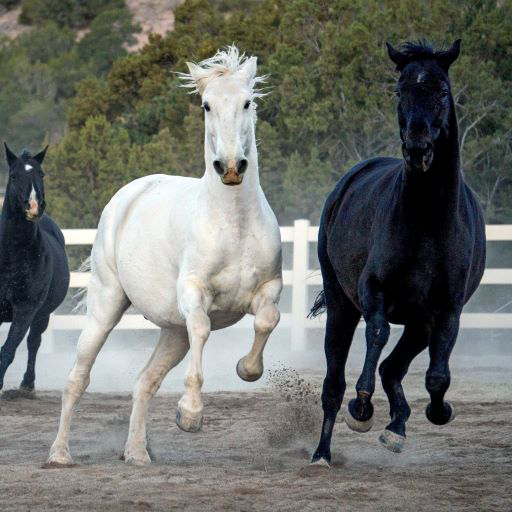

In [87]:
from PIL import Image
from torchvision import transforms
preprocess = transforms.Compose([transforms.Resize(256),
    transforms.ToTensor()])
img2 = Image.open("Horse2.jpg")
img2

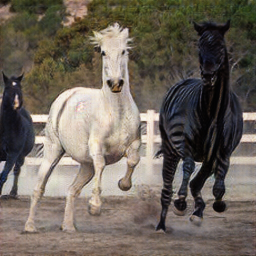

In [22]:
img_t2 = preprocess(img2)
batch_z2 = torch.unsqueeze(img_t2, 0)
batch_out2 = netG(batch_z2)
#Run image through model and obtain altered image
out_t2 = (batch_out2.data.squeeze() + 1.0) / 2.0
out_img2 = transforms.ToPILImage()(out_t2)
out_img2.save("Zebra2.jpg")
out_img2

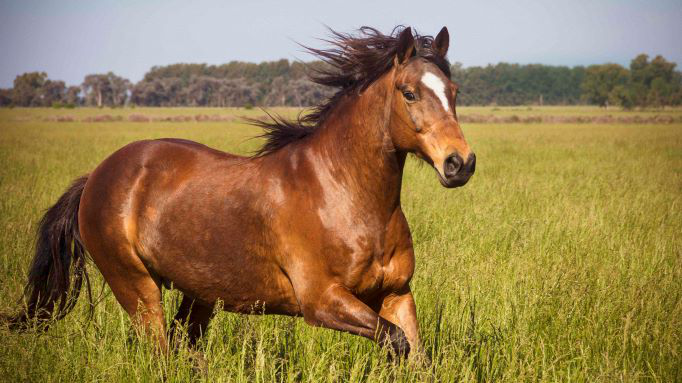

In [88]:
from PIL import Image
from torchvision import transforms
preprocess = transforms.Compose([transforms.Resize(256),
    transforms.ToTensor()])
img3 = Image.open("Horse3.jpg")
img3

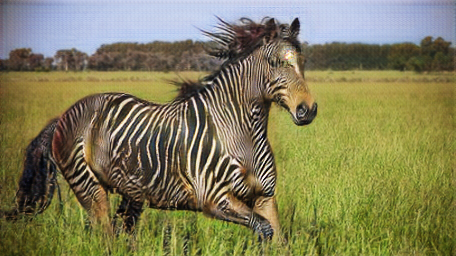

In [24]:
img_t3 = preprocess(img3)
batch_z3 = torch.unsqueeze(img_t3, 0)
batch_out3 = netG(batch_z3)
#Run image through model and obtain altered image
out_t3 = (batch_out3.data.squeeze() + 1.0) / 2.0
out_img3 = transforms.ToPILImage()(out_t3)
out_img3.save("Zebra3.jpg")
out_img3

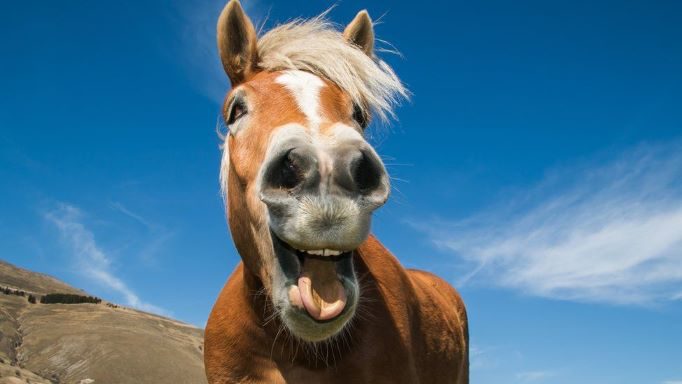

In [89]:
from PIL import Image
from torchvision import transforms
preprocess = transforms.Compose([transforms.Resize(256),
    transforms.ToTensor()])
img4 = Image.open("Horse4.jpg")
img4

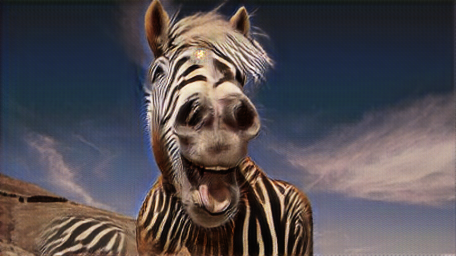

In [26]:
img_t4 = preprocess(img4)
batch_z4 = torch.unsqueeze(img_t4, 0)
batch_out4 = netG(batch_z4)
#Run image through model and obtain altered image
out_t4 = (batch_out4.data.squeeze() + 1.0) / 2.0
out_img4 = transforms.ToPILImage()(out_t4)
out_img4.save("Zebra4.jpg")
out_img4

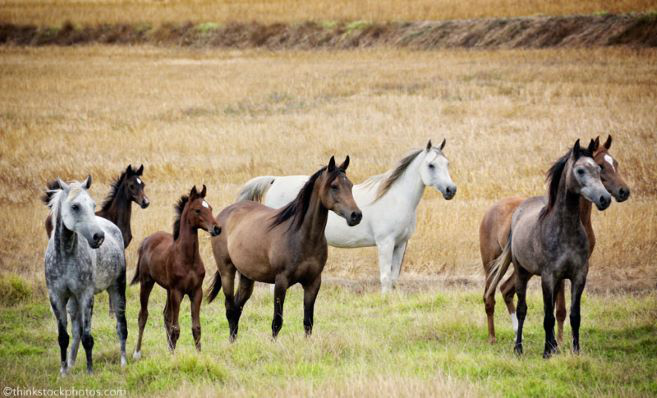

In [90]:
from PIL import Image
from torchvision import transforms
preprocess = transforms.Compose([transforms.Resize(256),
    transforms.ToTensor()])
img5 = Image.open("Horse5.jpg")
img5

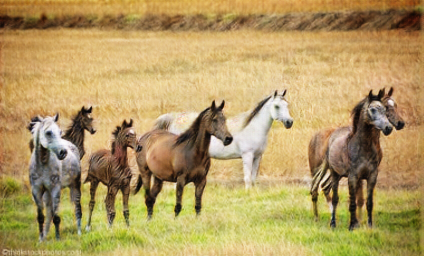

In [28]:
img_t5 = preprocess(img5)
batch_z5 = torch.unsqueeze(img_t5, 0)
batch_out5 = netG(batch_z5)
#Run image through model and obtain altered image
out_t5 = (batch_out5.data.squeeze() + 1.0) / 2.0
out_img5 = transforms.ToPILImage()(out_t5)
out_img5.save("Zebra5.jpg")
out_img5

In [29]:
#Problem 3
from ptflops import get_model_complexity_info

#Complexity of resnet101:
with torch.cuda.device(0):
  net = resnet101
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ResNet(
  44.549 M, 100.000% Params, 7.85 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.009 M, 0.021% Params, 0.118 GMac, 1.503% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(0.0 M, 0.000% Params, 0.002 GMac, 0.020% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0.0 M, 0.000% Params, 0.001 GMac, 0.010% MACs, inplace=True)
  (maxpool): MaxPool2d(0.0 M, 0.000% Params, 0.001 GMac, 0.010% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    0.216 M, 0.484% Params, 0.68 GMac, 8.668% MACs, 
    (0): Bottleneck(
      0.075 M, 0.168% Params, 0.236 GMac, 3.012% MACs, 
      (conv1): Conv2d(0.004 M, 0.009% Params, 0.013 GMac, 0.164% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(0.0 M, 0.000% Params, 0.0 GMac, 0.005% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(0.037 M, 0.0

In [35]:
with torch.cuda.device(0):
  net = ResNetGenerator()
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=False, verbose=False)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       43.55 GMac
Number of parameters:           11.38 M 


In [30]:
#Complexity of Zebras:
with torch.cuda.device(0):
  net = netG
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ResNetGenerator(
  11.378 M, 100.000% Params, 43.555 GMac, 100.000% MACs, 
  (model): Sequential(
    11.378 M, 100.000% Params, 43.555 GMac, 100.000% MACs, 
    (0): ReflectionPad2d(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, (3, 3, 3, 3))
    (1): Conv2d(0.009 M, 0.083% Params, 0.475 GMac, 1.091% MACs, 3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(0.0 M, 0.000% Params, 0.003 GMac, 0.007% MACs, 64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(0.0 M, 0.000% Params, 0.003 GMac, 0.007% MACs, inplace=True)
    (4): Conv2d(0.074 M, 0.649% Params, 0.926 GMac, 2.127% MACs, 64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(0.0 M, 0.000% Params, 0.002 GMac, 0.004% MACs, 128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(0.0 M, 0.000% Params, 0.002 GMac, 0.004% MACs, inplace=True)
    (7): Conv2d(0.295 M, 2.594% Params, 0.926 GMac, 2.125% MACs, 128, 256, kernel_size=(3, 3)

In [40]:
#Problem 4
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
mobilenet.eval()
#No idea what this means, however I do have output

Using cache found in C:\Users\mcafo/.cache\torch\hub\pytorch_vision_v0.10.0


MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [45]:
input_img = preprocess(Giraffe) #replace variable in arg to desired image
input_batch = input_img.unsqueeze(0)
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    mobilenet.to('cuda')    
with torch.no_grad():
    output = mobilenet(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)


tensor([-4.9821e+00, -2.4152e+00, -4.5006e+00, -2.4676e+00, -4.9465e+00,
        -2.7810e-01, -3.3780e+00,  2.7252e+00,  2.7775e+00,  5.3490e+00,
         1.5439e+00, -3.9001e+00, -8.3813e-03, -6.7910e+00, -3.0006e+00,
         1.8756e+00, -1.6537e+00,  6.3435e-01, -1.8556e+00, -4.8989e+00,
        -1.7931e+00,  7.7989e+00,  7.4766e-01,  5.2639e+00,  2.5466e+00,
        -2.1456e+00,  2.9178e+00,  2.9552e-01, -2.6718e+00, -2.7939e+00,
        -1.1023e+00, -4.3490e+00,  1.4999e+00,  3.9891e+00,  5.2829e+00,
         1.0126e+00,  2.3684e+00, -1.4130e+00,  5.1520e+00, -2.4402e+00,
        -6.0121e-01,  4.7904e+00,  2.2827e+00,  1.8237e+00,  8.2765e-02,
         9.6213e-01, -1.9841e+00,  2.7362e+00, -3.0710e+00, -1.3186e+00,
        -3.4502e+00,  1.8257e+00,  2.5130e+00, -2.5987e-01,  5.3712e+00,
        -4.7167e+00,  7.6150e-01, -1.6651e+00, -1.4426e+00,  1.5918e+00,
         2.1252e+00,  2.0984e+00,  2.7630e+00,  4.5987e+00, -2.4217e+00,
        -5.6184e-02,  3.3203e+00,  1.4212e+00,  2.5

In [46]:
#Get class labels
with open("imagenet_classes.txt") as f:
    labels = [line.strip() for line in f.readlines()]
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
_, indices = torch.sort(output, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('cheetah, chetah, Acinonyx jubatus', 50.128692626953125),
 ('leopard, Panthera pardus', 20.423933029174805),
 ('hyena, hyaena', 5.638676643371582),
 ('zebra', 4.835460186004639),
 ('jaguar, panther, Panthera onca, Felis onca', 4.485785007476807)]

In [47]:
#Complexity of mobilenetv2:
with torch.cuda.device(0):
  net = mobilenet
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

MobileNetV2(
  3.505 M, 100.000% Params, 0.32 GMac, 100.000% MACs, 
  (features): Sequential(
    2.224 M, 63.451% Params, 0.319 GMac, 99.600% MACs, 
    (0): ConvNormActivation(
      0.001 M, 0.026% Params, 0.012 GMac, 3.760% MACs, 
      (0): Conv2d(0.001 M, 0.025% Params, 0.011 GMac, 3.384% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(0.0 M, 0.002% Params, 0.001 GMac, 0.251% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(0.0 M, 0.000% Params, 0.0 GMac, 0.125% MACs, inplace=True)
    )
    (1): InvertedResidual(
      0.001 M, 0.026% Params, 0.012 GMac, 3.635% MACs, 
      (conv): Sequential(
        0.001 M, 0.026% Params, 0.012 GMac, 3.635% MACs, 
        (0): ConvNormActivation(
          0.0 M, 0.010% Params, 0.005 GMac, 1.504% MACs, 
          (0): Conv2d(0.0 M, 0.008% Params, 0.004 GMac, 1.128% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)

In [48]:
input_img = preprocess(Ostrich) #replace variable in arg to desired image
input_batch = input_img.unsqueeze(0)
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    mobilenet.to('cuda')  
with torch.no_grad():
    output = mobilenet(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

tensor([ 2.1154e+00, -3.0227e+00,  2.0645e+00,  1.8560e+00, -4.3890e-01,
        -2.6670e+00, -3.4516e+00,  5.5676e+00,  7.5518e+00,  2.8010e+01,
        -1.8608e+00,  1.7957e+00,  2.3057e+00, -2.5371e-01, -2.2924e+00,
        -3.5767e+00, -3.1201e-01,  5.9672e-01,  1.5411e+00,  2.1479e-01,
        -5.9843e+00,  2.3232e+00,  2.4616e+00,  1.1121e+01, -3.1345e-01,
        -4.1285e+00,  1.9348e+00,  1.1558e+00, -2.7882e+00, -1.5995e-01,
        -1.6160e+00,  1.7133e+00,  2.8432e+00, -3.7696e+00, -2.6141e+00,
        -1.4000e+00,  1.4736e-01,  5.0973e-01,  5.9812e+00,  9.2987e+00,
         3.7778e+00,  5.8794e+00,  4.8801e+00,  9.9780e+00,  4.7907e+00,
         1.4489e+00,  4.9420e+00,  5.0890e+00,  5.6035e+00,  5.0693e+00,
         4.3566e+00, -6.6227e-01,  3.4427e+00, -3.8009e+00,  2.6791e+00,
        -1.0571e+00, -3.0314e+00,  8.9030e-01, -2.8510e+00,  4.4633e+00,
         2.9121e+00,  2.8834e+00,  4.0275e+00,  4.7841e+00,  2.1804e+00,
         3.1198e-01,  2.8166e+00,  3.0041e+00,  2.1

In [52]:
#Get class labels
with open("imagenet_classes.txt") as f:
    labels = [line.strip() for line in f.readlines()]
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
_, indices = torch.sort(output, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('ostrich, Struthio camelus', 99.9998550415039),
 ('llama', 2.2893213099450804e-05),
 ('bustard', 2.1242985894787125e-05),
 ('macaque', 1.6861973563209176e-05),
 ('sloth bear, Melursus ursinus, Ursus ursinus', 1.5745610653539188e-05)]

In [53]:
#Complexity of mobilenetv2:
with torch.cuda.device(0):
  net = mobilenet
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

MobileNetV2(
  3.505 M, 100.000% Params, 0.32 GMac, 100.000% MACs, 
  (features): Sequential(
    2.224 M, 63.451% Params, 0.319 GMac, 99.600% MACs, 
    (0): ConvNormActivation(
      0.001 M, 0.026% Params, 0.012 GMac, 3.760% MACs, 
      (0): Conv2d(0.001 M, 0.025% Params, 0.011 GMac, 3.384% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(0.0 M, 0.002% Params, 0.001 GMac, 0.251% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(0.0 M, 0.000% Params, 0.0 GMac, 0.125% MACs, inplace=True)
    )
    (1): InvertedResidual(
      0.001 M, 0.026% Params, 0.012 GMac, 3.635% MACs, 
      (conv): Sequential(
        0.001 M, 0.026% Params, 0.012 GMac, 3.635% MACs, 
        (0): ConvNormActivation(
          0.0 M, 0.010% Params, 0.005 GMac, 1.504% MACs, 
          (0): Conv2d(0.0 M, 0.008% Params, 0.004 GMac, 1.128% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)

In [57]:
input_img = preprocess(Poodle) #replace variable in arg to desired image
input_batch = input_img.unsqueeze(0)
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    mobilenet.to('cuda')  
with torch.no_grad():
    output = mobilenet(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

tensor([ 2.0464e-01, -1.9329e+00,  1.4372e+00, -6.1503e-01, -3.5165e+00,
         4.0602e-01, -4.5070e+00,  2.2964e+00,  3.9922e+00,  1.0541e+00,
         3.2008e+00,  7.6138e-01,  4.1030e+00, -2.0977e+00, -1.2239e+00,
        -3.6314e-01, -5.4040e-01, -4.3965e-01, -3.6692e+00, -5.1774e-01,
        -4.9261e+00,  2.0241e+00, -2.4610e+00,  3.6999e+00,  2.5502e+00,
        -1.6103e+00, -6.3383e-01, -2.6282e+00, -2.1802e+00, -1.9078e+00,
        -4.1461e+00, -2.7441e+00, -8.3466e-01, -4.2966e-01,  1.7328e+00,
        -7.5748e-01,  1.6973e+00, -9.1852e-01,  5.4211e+00,  6.4376e+00,
         1.3949e+00,  6.5920e+00,  3.2353e+00,  3.5291e+00,  7.7182e-01,
         3.1502e+00,  6.1127e-01,  1.8056e+00,  2.4255e+00, -2.2289e+00,
        -9.9458e-01,  2.0383e+00, -1.0120e+00, -2.5682e+00, -1.4443e+00,
        -3.9102e+00,  2.1173e-01, -1.9513e+00, -2.3531e-01, -1.2353e+00,
        -1.8575e-01, -3.1551e-01,  9.4889e-01,  2.6338e+00, -5.4919e-01,
        -4.9318e-01,  2.1718e+00,  3.6084e-01,  2.1

In [58]:
#Get class labels
with open("imagenet_classes.txt") as f:
    labels = [line.strip() for line in f.readlines()]
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
_, indices = torch.sort(output, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('clumber, clumber spaniel', 26.492061614990234),
 ('tiger, Panthera tigris', 21.60841941833496),
 ('tiger cat', 10.151528358459473),
 ('zebra', 5.982939720153809),
 ('prairie chicken, prairie grouse, prairie fowl', 4.674432277679443)]

In [59]:
#Complexity of mobilenetv2:
with torch.cuda.device(0):
  net = mobilenet
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

MobileNetV2(
  3.505 M, 100.000% Params, 0.32 GMac, 100.000% MACs, 
  (features): Sequential(
    2.224 M, 63.451% Params, 0.319 GMac, 99.600% MACs, 
    (0): ConvNormActivation(
      0.001 M, 0.026% Params, 0.012 GMac, 3.760% MACs, 
      (0): Conv2d(0.001 M, 0.025% Params, 0.011 GMac, 3.384% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(0.0 M, 0.002% Params, 0.001 GMac, 0.251% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(0.0 M, 0.000% Params, 0.0 GMac, 0.125% MACs, inplace=True)
    )
    (1): InvertedResidual(
      0.001 M, 0.026% Params, 0.012 GMac, 3.635% MACs, 
      (conv): Sequential(
        0.001 M, 0.026% Params, 0.012 GMac, 3.635% MACs, 
        (0): ConvNormActivation(
          0.0 M, 0.010% Params, 0.005 GMac, 1.504% MACs, 
          (0): Conv2d(0.0 M, 0.008% Params, 0.004 GMac, 1.128% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)

In [60]:
input_img = preprocess(Thanos) #replace variable in arg to desired image
input_batch = input_img.unsqueeze(0)
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    mobilenet.to('cuda')    
with torch.no_grad():
    output = mobilenet(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

tensor([ 1.7759, -0.3995,  0.1024,  2.7523, -0.9908, -1.5551, -0.7694, -1.3691,
        -2.8870, -4.3407,  1.5839,  0.0554,  2.7214,  0.5512, -1.3751, -0.7672,
        -1.8486, -2.2535, -2.3151, -0.9849, -0.2648,  2.6169, -0.8370, -0.6194,
        -1.0857, -3.3445, -2.2278, -2.3658, -2.3158, -3.5003, -3.3505, -3.2854,
        -3.7150, -1.4398, -1.8749, -1.6296,  0.1039, -1.4971, -0.7184, -2.4789,
        -1.6808, -3.9483, -2.9612, -1.1420, -2.9986, -2.0069, -2.7943,  0.1844,
        -3.3541, -2.8557, -2.6553, -1.2276, -1.0007, -0.9223, -1.2081,  0.9256,
        -3.2185, -3.4523, -2.1362,  3.0118, -0.1762,  0.0644,  1.3420,  4.8822,
         2.9722,  0.0524, -0.7211, -2.5810, -0.6448,  0.6216, -4.8848,  3.9263,
        -3.7689, -3.0018, -5.1002, -3.5794, -4.4070, -4.4555, -2.0644, -2.2939,
        -2.7068, -3.1511, -1.1437, -2.5021, -4.2205, -2.6476,  0.4525,  1.9650,
        -0.1582, -3.4689,  1.5586, -1.0978,  0.3718, -0.2261, -1.7486, -4.0451,
        -1.9139, -1.2640, -1.7945, -1.68

In [61]:
#Get class labels
with open("imagenet_classes.txt") as f:
    labels = [line.strip() for line in f.readlines()]
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
_, indices = torch.sort(output, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('neck brace', 33.213768005371094),
 ('pickelhaube', 18.748390197753906),
 ('barbershop', 13.158500671386719),
 ('cuirass', 2.56059193611145),
 ('vestment', 2.3709421157836914)]

In [62]:
#Complexity of mobilenetv2:
with torch.cuda.device(0):
  net = mobilenet
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

MobileNetV2(
  3.505 M, 100.000% Params, 0.32 GMac, 100.000% MACs, 
  (features): Sequential(
    2.224 M, 63.451% Params, 0.319 GMac, 99.600% MACs, 
    (0): ConvNormActivation(
      0.001 M, 0.026% Params, 0.012 GMac, 3.760% MACs, 
      (0): Conv2d(0.001 M, 0.025% Params, 0.011 GMac, 3.384% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(0.0 M, 0.002% Params, 0.001 GMac, 0.251% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(0.0 M, 0.000% Params, 0.0 GMac, 0.125% MACs, inplace=True)
    )
    (1): InvertedResidual(
      0.001 M, 0.026% Params, 0.012 GMac, 3.635% MACs, 
      (conv): Sequential(
        0.001 M, 0.026% Params, 0.012 GMac, 3.635% MACs, 
        (0): ConvNormActivation(
          0.0 M, 0.010% Params, 0.005 GMac, 1.504% MACs, 
          (0): Conv2d(0.0 M, 0.008% Params, 0.004 GMac, 1.128% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)

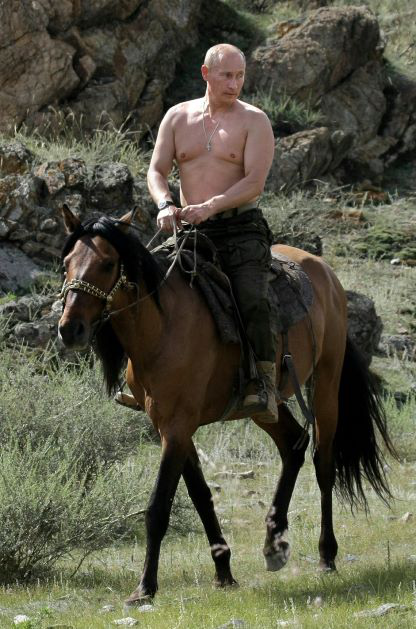

In [91]:
#Import image of a horse
from PIL import Image
from torchvision import transforms
preprocess = transforms.Compose([transforms.Resize(256),
    transforms.ToTensor()])
img = Image.open("Putin.jpg")
img

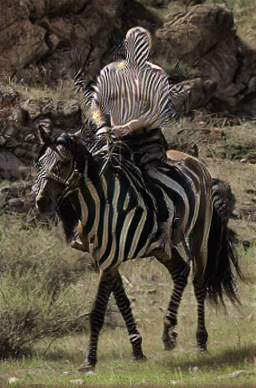

In [68]:
img_t = preprocess(img)
batch_z = torch.unsqueeze(img_t, 0)
batch_out = netG(batch_z)
#Run image through model and obtain altered image
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img.save("PutinZebra.jpg")
out_img